### 교차검증

In [ ]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np

boston = load_boston()

dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([dfX, dfy], axis=1)

#학습용과 검증용을 7:3으로 구분
N = len(df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int64(ratio * N),replace=False)   #replace=F > 비복원추출
idx_test = list(set(np.arange(N)).difference(idx_train))        #difference > 차집합

df_train = df.iloc[idx_train]
df_test = df.iloc[idx_test]

In [2]:
import statsmodels.api as sm

model = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     70.06
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           8.57e-88
Time:                        11:00:35   Log-Likelihood:                -1043.0
No. Observations:                 354   AIC:                             2114.
Df Residuals:                     340   BIC:                             2168.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.0719      5.932      5.913      0.0

In [3]:
#검증용 데이터셋으로 모형 평가
pred = result.predict(df_test)

# Residual Sum of Square(잔차의 분산, 오차의 크기)
rss = ((df_test.MEDV - pred) ** 2).sum()

# Total Sum of Square(종속변수 y의 분산)
tss = ((df_test.MEDV - df_test.MEDV.mean())** 2).sum()

# 결정계수: 모형의 설명력(0~1 사이의 값)
rsquared = 1 - rss / tss
rsquared

0.7519796502601109

In [4]:
##위에서 한 걸 간단히 하는 받법 1
from sklearn.model_selection import train_test_split

#학습용,검증용으로 구분
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)
df_train.shape, df_test.shape

((354, 14), (152, 14))

In [5]:
##위에서 한 걸 간단히 하는 받법 2
#학습용X,y 검증용 X,y로 구분
dfX_train, dfX_test, dfy_train, dfy_test = train_test_split(dfX, dfy, test_size=0.3, random_state=0)
dfX_train.shape, dfy_train.shape, dfX_test.shape, dfy_test.shape

((354, 13), (354, 1), (152, 13), (152, 1))

In [7]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
 df_train = df.iloc[idx_train]
 df_test = df.iloc[idx_test]

 model = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df_train)
 result = model.fit()

 pred = result.predict(df_test)
 rss = ((df_test.MEDV - pred) ** 2).sum()
 tss = ((df_test.MEDV - df_test.MEDV.mean())** 2).sum()
 rsquared = 1 - rss / tss

 scores[i] = rsquared
 print(f"학습용 R2 = {result.rsquared:.3f}, 검증용 R2 = {rsquared:.3f}")

학습용 R2 = 0.773, 검증용 R2 = 0.589
학습용 R2 = 0.729, 검증용 R2 = 0.778
학습용 R2 = 0.749, 검증용 R2 = 0.668
학습용 R2 = 0.757, 검증용 R2 = 0.668
학습용 R2 = 0.705, 검증용 R2 = 0.840


In [8]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

scores1 = np.zeros(5)
scores2 = np.zeros(5)
scores3 = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
 df_train = df.iloc[idx_train]
 df_test = df.iloc[idx_test]

 model = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df_train)
 result = model.fit()

 pred = result.predict(df_test)
 #결정계수를 구하는 함수
 rsquared = r2_score(df_test.MEDV, pred)
 scores1[i] = rsquared
 #평균제곱오차(Mean Squared Error) - 오차의 제곱의 합계의 평균값
 mse = mean_squared_error(df_test.MEDV, pred)
 scores2[i] = mse
 #평균절대오차(Mean Absolute Error) - 오차의 젇대값의 합계의 평균값
 mae = mean_absolute_error(df_test.MEDV, pred)
 scores3[i] = mae

print(scores1)
print(scores2)
print(scores3)

[0.58922238 0.77799144 0.66791979 0.6680163  0.83953317]
[33.44898    18.65881615 21.23463289 29.22251557 16.57369039]
[3.84290922 3.38979394 3.07473854 3.6463452  3.03058651]


In [10]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm

class StatsmodelsOLS(BaseEstimator, RegressorMixin):
 def __init__(self, formula):
    self.formula = formula
    self.model = None
    self.data = None
    self.result = None

 def fit(self, dfX, dfy):
    self.data = pd.concat([dfX, dfy], axis=1)
    self.model = smf.ols(self.formula, data=self.data)
    self.result = self.model.fit()

 def predict(self, new_data):
    return self.result.predict(new_data)

In [11]:
from sklearn.model_selection import cross_val_score

model = StatsmodelsOLS("MEDV ~ " + "+".join(boston.feature_names))
cv = KFold(5, shuffle=True, random_state=0)
cross_val_score(model, dfX, dfy, scoring="r2", cv=cv)
#평균제곱오차로 평가하는 경우
result=cross_val_score(model, dfX, dfy, scoring='neg_mean_squared_error', cv=cv)
#음수로 나온 결과값을 양수로 변환
rmse_score = np.sqrt(-result)
rmse_score

array([5.78350932, 4.31958518, 4.60810513, 5.40578538, 4.07107976])

### 주택 가격 예측2

In [13]:
df = pd.read_csv("c:/vscode/data/house_data.csv")
df.head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0


In [15]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [16]:
X= df.loc[ : , ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Propertycount']]
y = df["Price"]
df2=pd.concat([X,y],axis=1)

In [20]:
df2

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Propertycount,Price
0,2,2.5,2.0,1.0,1.0,126.0,NaN,4019.0,NaN
1,2,2.5,2.0,1.0,1.0,202.0,NaN,4019.0,1480000.0
2,2,2.5,2.0,1.0,0.0,156.0,79.0,4019.0,1035000.0
3,3,2.5,3.0,2.0,1.0,0.0,NaN,4019.0,NaN
4,3,2.5,3.0,2.0,0.0,134.0,150.0,4019.0,1465000.0
...,...,...,...,...,...,...,...,...,...
19735,2,4.6,3.0,1.0,1.0,NaN,585.0,4380.0,560000.0
19736,3,25.5,3.0,2.0,2.0,NaN,333.0,2940.0,525300.0
19737,2,6.3,3.0,2.0,2.0,1999.0,199.0,6543.0,750000.0
19738,6,6.3,3.0,2.0,1.0,2011.0,238.0,6543.0,2450000.0


In [19]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
df3 = pd.DataFrame(imputer.fit_transform(df2), columns=df2.columns)
df3

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Propertycount,Price
0,2.0,2.5,2.0,1.0,1.0,126.00000,196.806973,4019.0,1.054957e+06
1,2.0,2.5,2.0,1.0,1.0,202.00000,196.806973,4019.0,1.480000e+06
2,2.0,2.5,2.0,1.0,0.0,156.00000,79.000000,4019.0,1.035000e+06
3,3.0,2.5,3.0,2.0,1.0,0.00000,196.806973,4019.0,1.054957e+06
4,3.0,2.5,3.0,2.0,0.0,134.00000,150.000000,4019.0,1.465000e+06
...,...,...,...,...,...,...,...,...,...
19735,2.0,4.6,3.0,1.0,1.0,583.91709,585.000000,4380.0,5.600000e+05
19736,3.0,25.5,3.0,2.0,2.0,583.91709,333.000000,2940.0,5.253000e+05
19737,2.0,6.3,3.0,2.0,2.0,1999.00000,199.000000,6543.0,7.500000e+05
19738,6.0,6.3,3.0,2.0,1.0,2011.00000,238.000000,6543.0,2.450000e+06


In [21]:
cols=df3.columns[:-1]
X=df3[cols]
y=df3['Price']

In [25]:
#다중 회귀분석
import statsmodels.api as sm

model = sm.OLS(y, X)
result = model.fit()

print("회귀계수\n",result.params)
print("R-squared\n",result.rsquared)
print("P values\n",result.pvalues)

회귀계수
 Rooms            294371.005153
Distance         -23496.988924
Bedroom2           9619.034190
Bathroom         153450.013874
Car               45814.483818
Landsize              0.670134
BuildingArea         19.118400
Propertycount         7.495786
dtype: float64
R-squared
 0.8320357616277432
P values
 Rooms             0.000000e+00
Distance         3.070252e-284
Bedroom2          1.150098e-01
Bathroom         1.468789e-106
Car               2.508850e-24
Landsize          5.287350e-01
BuildingArea      4.347287e-02
Propertycount     8.631029e-27
dtype: float64


In [26]:
#요약 결과 출력
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.832
Model:                            OLS   Adj. R-squared (uncentered):              0.832
Method:                 Least Squares   F-statistic:                          1.222e+04
Date:                Thu, 09 Mar 2023   Prob (F-statistic):                        0.00
Time:                        11:51:06   Log-Likelihood:                     -2.8670e+05
No. Observations:               19740   AIC:                                  5.734e+05
Df Residuals:                   19732   BIC:                                  5.735e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [27]:
#가장 유의하지 않은 Landsize 제외
X= df3.loc[ : , ['Rooms', 'Car','Distance', 'Bedroom2','Bathroom', 'BuildingArea', 'Propertycount']]
y = df3["Price"]

In [29]:
# Bedroom2 제외
X= df3.loc[ : , ['Rooms', 'Car','Distance', 'Bathroom','BuildingArea', 'Propertycount']]
y = df3["Price"]

In [30]:
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.832
Model:                            OLS   Adj. R-squared (uncentered):              0.832
Method:                 Least Squares   F-statistic:                          1.629e+04
Date:                Thu, 09 Mar 2023   Prob (F-statistic):                        0.00
Time:                        11:52:36   Log-Likelihood:                     -2.8670e+05
No. Observations:               19740   AIC:                                  5.734e+05
Df Residuals:                   19734   BIC:                                  5.735e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#데이터셋을 나눔(학습용:검증용 = 8:2)
#random_state : 난수 발생을 위한 seed의 인자값
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
model = LinearRegression().fit(X_train, y_train)

In [34]:
print("전체:",model.score(X, y))
print("학습용:",model.score(X_train, y_train))
print("검증용:",model.score(X_test, y_test))

전체: 0.27992452956040537
학습용: 0.2782266519925297
검증용: 0.2872826823410175


### 범주형 독립변수

In [35]:
#1920~1939년 노팅엄 지역 월 평균 기온 데이터
import pandas as pd
df = pd.read_csv('c:/vscode/data/degree_data.csv')
df

,year,month,value
0,1920,1,40.6
1,1920,2,40.8
2,1920,3,44.4
3,1920,4,46.7
4,1920,5,54.1
...,...,...,...
235,1939,8,61.8
236,1939,9,58.2
237,1939,10,46.7
238,1939,11,46.6


<AxesSubplot:title={'center':'value'}, xlabel='month'>

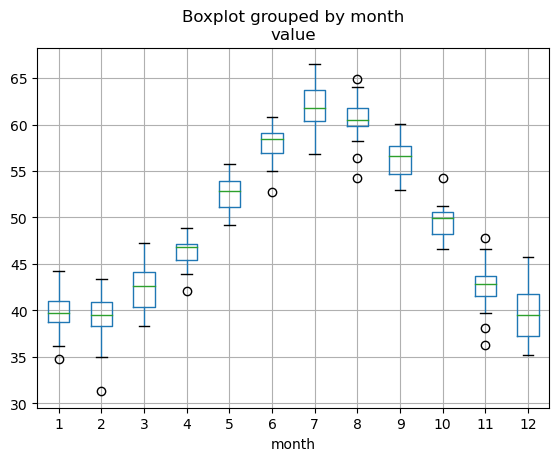

In [36]:
df.boxplot("value", "month")

In [37]:
import statsmodels.api as sm
#카테고리형 변수인 월이 연속숫자형으로 인식되지 않도록 C() 함수 사용
# +0을 붙이면 1월~12월이 평균기온으로 처리됨
# coef는 월의 평균기온
model = sm.OLS.from_formula("value ~ C(month)+0", df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     277.3
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          2.96e-125
Time:                        12:10:21   Log-Likelihood:                -535.82
No. Observations:                 240   AIC:                             1096.
Df Residuals:                     228   BIC:                             1137.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[1]     39.6950      0.518     76.691      0.000      38.675      40.715
C(month)[2]     39.1900      0.518     75.716      0.000      38.170      40.210
C(month)[3]     42.1950      0.518     81.521      0.000      41.175      43.215
C(month)[4]     46.2900      0.518     89.433      0.000      45.270      47.310
C(month)[5]     52.5600      0.518    101.547      0.000      51.540      53.580
C(month)[6]     58.0400      0.518    112.134      0.000      57.020      59.060
C(month)[7]     61.9000      0.518    119.592      0.000      60.880      62.920
C(month)[8]     60.5200      0.518    116.926      0.000      59.500      61.540
C(month)[9]     56.4800      0.518    109.120      0.000      55.460      57.500
C(month)[10]    49.4950      0.518     95.625      0.000      48.475      50.515
C(month)[11]    42.5800      0.518     82.265      0.000      41.560      43.600
C(month)[12]    39.5300      0.518     76.373      0.000      38.510      40.550
==============================================================================
Omnibus:                        5.430   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                5.299
Skew:                          -0.281   Prob(JB):                       0.0707
Kurtosis:                       3.463   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# +0이 없으면 첫번째 변수인 1월은 제외하고 1월을 기준으로 각 월의 평균 기온이
# 1월보다 얼마나 더 높은지 낮은지를 나타내는 값이 회귀모형의 계수가 된다.
model = sm.OLS.from_formula("value ~ C(month)", df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     277.3
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          2.96e-125
Time:                        12:11:06   Log-Likelihood:                -535.82
No. Observations:                 240   AIC:                             1096.
Df Residuals:                     228   BIC:                             1137.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         39.6950      0.518     76.691      0.000      38.675      40.715
C(month)[T.2]     -0.5050      0.732     -0.690      0.491      -1.947       0.937
C(month)[T.3]      2.5000      0.732      3.415      0.001       1.058       3.942
C(month)[T.4]      6.5950      0.732      9.010      0.000       5.153       8.037
C(month)[T.5]     12.8650      0.732     17.575      0.000      11.423      14.307
C(month)[T.6]     18.3450      0.732     25.062      0.000      16.903      19.787
C(month)[T.7]     22.2050      0.732     30.335      0.000      20.763      23.647
C(month)[T.8]     20.8250      0.732     28.450      0.000      19.383      22.267
C(month)[T.9]     16.7850      0.732     22.931      0.000      15.343      18.227
C(month)[T.10]     9.8000      0.732     13.388      0.000       8.358      11.242
C(month)[T.11]     2.8850      0.732      3.941      0.000       1.443       4.327
C(month)[T.12]    -0.1650      0.732     -0.225      0.822      -1.607       1.277
==============================================================================
Omnibus:                        5.430   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                5.299
Skew:                          -0.281   Prob(JB):                       0.0707
Kurtosis:                       3.463   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 부분회귀 플롯
* 부분회귀플롯: 독립변수가 여러개일 때 특정한 하나의 독립변수의 영향력을 시각화하는 방법

In [40]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([dfX, dfy], axis=1)
df

c:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fu

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [41]:
import statsmodels.api as sm

model = sm.OLS(dfy, dfX)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              891.3
Date:                Thu, 09 Mar 2023   Prob (F-statistic):                        0.00
Time:                        12:33:29   Log-Likelihood:                         -1523.8
No. Observations:                 506   AIC:                                      3074.
Df Residuals:                     493   BIC:                                      3128.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.0929      0.034     -2.699      0.007      -0.161      -0.025
ZN             0.0487      0.014      3.382      0.001       0.020       0.077
INDUS         -0.0041      0.064     -0.063      0.950      -0.131       0.123
CHAS           2.8540      0.904      3.157      0.002       1.078       4.630
NOX           -2.8684      3.359     -0.854      0.394      -9.468       3.731
RM             5.9281      0.309     19.178      0.000       5.321       6.535
AGE           -0.0073      0.014     -0.526      0.599      -0.034       0.020
DIS           -0.9685      0.196     -4.951      0.000      -1.353      -0.584
RAD            0.1712      0.067      2.564      0.011       0.040       0.302
TAX           -0.0094      0.004     -2.395      0.017      -0.017      -0.002
PTRATIO       -0.3922      0.110     -3.570      0.000      -0.608      -0.176
B              0.0149      0.003      5.528      0.000       0.010       0.020
LSTAT         -0.4163      0.051     -8.197      0.000      -0.516      -0.317
==============================================================================
Omnibus:                      204.082   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1374.225
Skew:                           1.609   Prob(JB):                    3.90e-299
Kurtosis:                      10.404   Cond. No.                     8.50e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='AGE', ylabel='MEDV'>

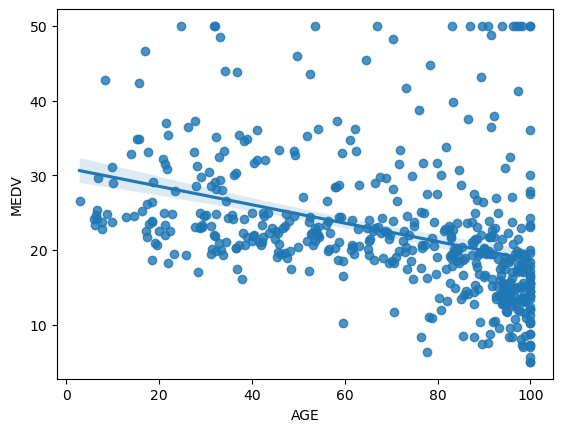

In [42]:
import seaborn as sns
sns.regplot(x="AGE", y="MEDV", data=df)
# age와 medv는 음의 상관관계가 있는 것처럼 보인다.
#이 부분플롯은 순수하게 age와 medv의 상관관계를 표현한 것이 아님.

In [43]:
# A.difference(B) A-B 차집합
others = list(set(df.columns).difference(set(["MEDV", "AGE"])))
others

['INDUS',
 'NOX',
 'LSTAT',
 'CHAS',
 'RM',
 'PTRATIO',
 'RAD',
 'TAX',
 'ZN',
 'B',
 'CRIM',
 'DIS']

eval_env: 1


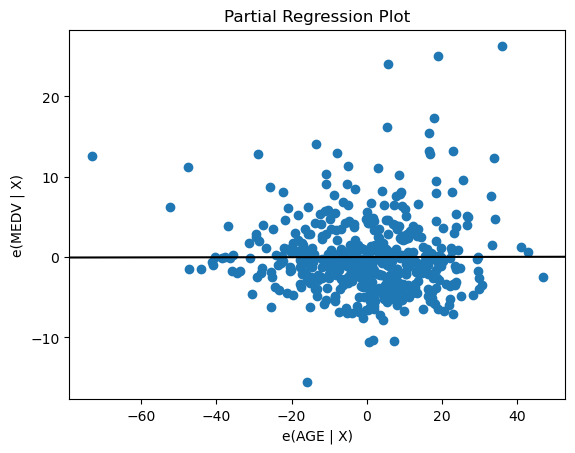

In [44]:
from statsmodels.graphics.regressionplots import plot_partregress
import matplotlib.pyplot as plt

# others : AGE를 제외한 나머지 독립변수들
# obs_labels : 데이터 라벨링 여부
plot_partregress("MEDV", "AGE", others, data=df, obs_labels=False)
plt.show()
#부분회귀 플롯을 볼 때 age와 medv는 상관관계가 없다.
#가로축의 값은 독립변수 자체의 값이 아닌
#어떤 독립변수에서 다른 독립변수의 영향을 제거한 값

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


[]

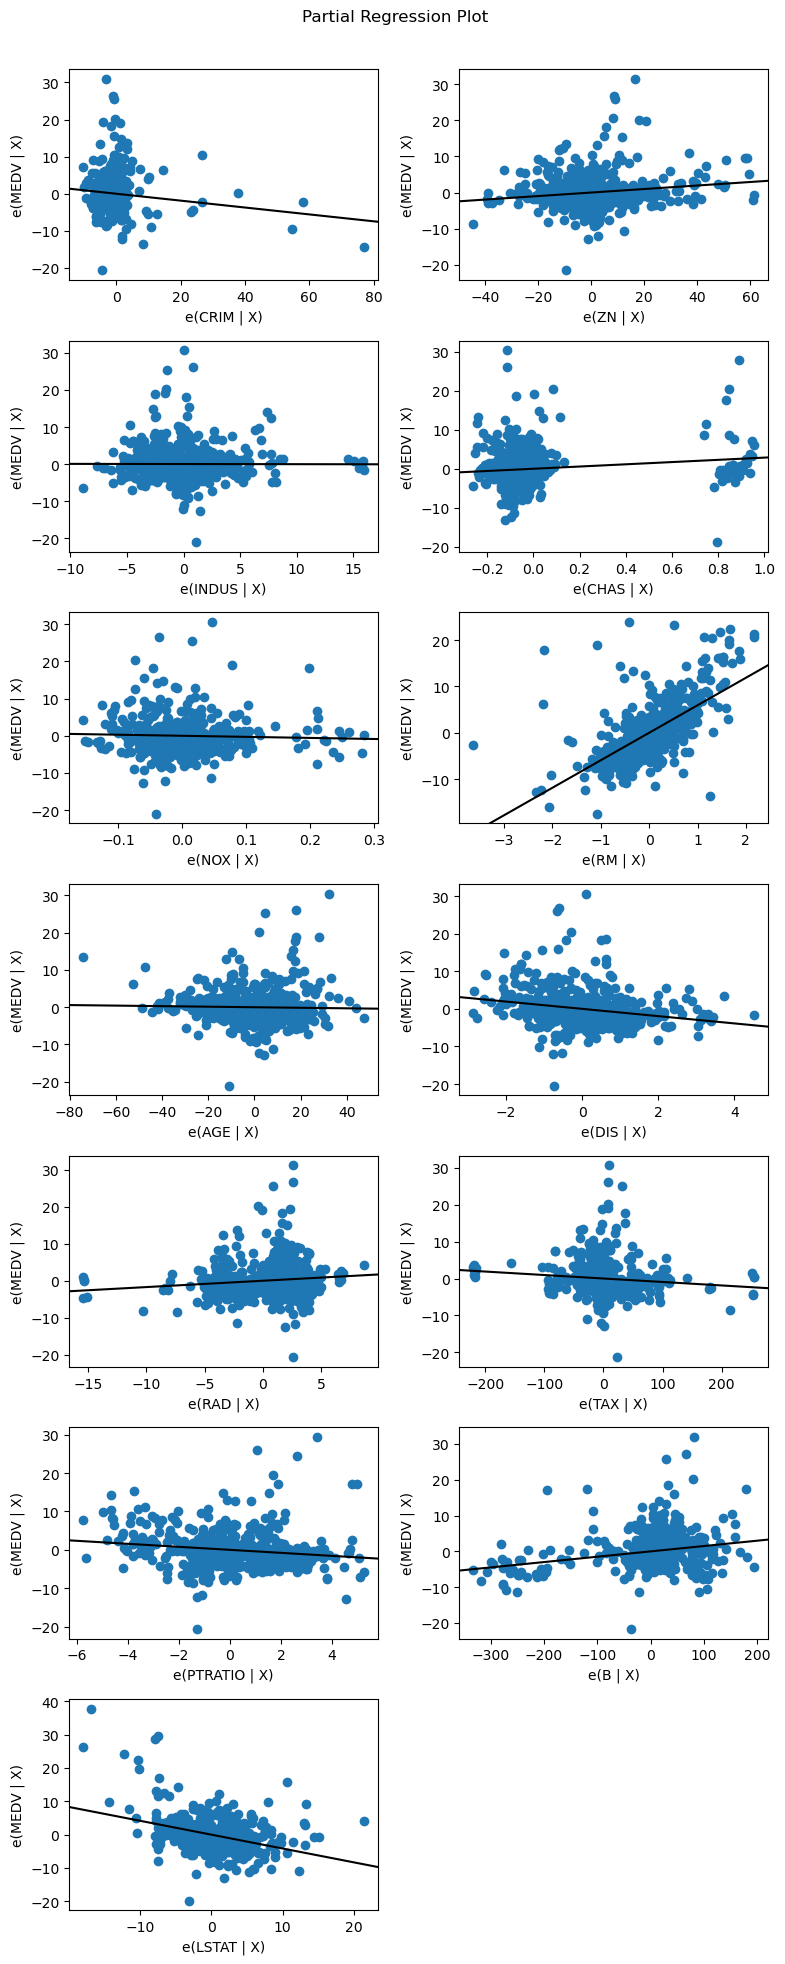

In [45]:
#전체 데이터에 대해 한번에 부분회귀 플롯을 그리는 함수
from statsmodels.graphics.regressionplots import plot_partregress_grid 

fig = plt.figure(figsize=(8, 20))
plot_partregress_grid(result, fig=fig)      # result: 학습 완료된 모형
plt.plot() 

### 보험료 예측

In [46]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
#전처리된 파일
data = pd.read_csv('c:/vscode/data/insurance2.csv')
data.head()

,age,sex,bmi,children,smoker,southwest,southeast,northeast,northwest,charges
0,19,0,27.900,0,1,1,0,0,0,16884.92400
1,18,1,33.770,1,0,0,1,0,0,1725.55230
2,28,1,33.000,3,0,0,1,0,0,4449.46200
3,33,1,22.705,0,0,0,0,0,1,21984.47061
4,32,1,28.880,0,0,0,0,0,1,3866.85520


In [53]:
data.corr()['charges'].sort_values()

southwest   -0.043210
northwest   -0.039905
northeast    0.006349
sex          0.057292
children     0.067998
southeast    0.073982
bmi          0.198341
age          0.299008
smoker       0.787251
charges      1.000000
Name: charges, dtype: float64

In [57]:
# 다중 회귀분석 

#독립변수
df2=data.iloc[:,[0,2,3]]
#종속변수
y2=data.iloc[:,[9]]

In [52]:
import statsmodels.api as sm

model = sm.OLS(y2, df2)
result = model.fit()
print("회귀계수\n",result.params)
print("R-squared\n",result.rsquared) #회귀모델의 설명력 59.5%의 설명력
print("P values\n",result.pvalues)
#요약 결과 출력
print(result.summary())

회귀계수
 age         205.509604
bmi         162.508428
children    407.682683
dtype: float64
R-squared
 0.5957184482734048
P values
 age         1.202690e-22
bmi         8.153462e-09
children    1.133688e-01
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.596
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              655.7
Date:                Thu, 09 Mar 2023   Prob (F-statistic):                   6.52e-262
Time:                        12:51:18   Log-Likelihood:                         -14400.
No. Observations:                1338   AIC:                                  2.881e+04
Df Residuals:                    1335   BIC:                                  2.882e+04
Df Model:                           3                                       

In [59]:
#유의하지 않은 children 변수 제거
df2=data.iloc[:,[0,2]]
#종속변수
y2=data.iloc[:,[9]]

model = sm.OLS(y2, df2)
result = model.fit()
print("회귀계수\n",result.params)
print("R-squared\n",result.rsquared)
print("P values\n",result.pvalues)
#요약 결과 출력
print(result.summary())

회귀계수
 age    208.863249
bmi    172.394322
dtype: float64
R-squared
 0.5949583640125078
P values
 age    1.634082e-23
bmi    3.773924e-10
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.594
Method:                 Least Squares   F-statistic:                              981.2
Date:                Thu, 09 Mar 2023   Prob (F-statistic):                   6.45e-263
Time:                        13:03:47   Log-Likelihood:                         -14401.
No. Observations:                1338   AIC:                                  2.881e+04
Df Residuals:                    1336   BIC:                                  2.882e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                   

### 레버리지와 이상치
* 레버리지(leverage, 지렛대/영향력) : 실제값이 예측값에 미치는 영향을 나타낸 값 (0~1 사이의 값)

In [60]:
from sklearn.datasets import make_regression
# 100개의 데이터 생성
X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20, coef=True, random_state=1)

In [61]:
import numpy as np
import statsmodels.api as sm

# 가상의 outlier 추가
data_100 = (4, 300)
data_101 = (3, 150)
X0 = np.vstack([X0, np.array([data_100[:1], data_101[:1]])])

# 회귀분석에서 수식을 간단하게 만들기 위해
# 독립변수의 첫번째 필드에 상수항 1을 추가(augmentation)
X = sm.add_constant(X0)
y = np.hstack([y, [data_100[1], data_101[1]]])

Text(0.5, 1.0, 'Regression')

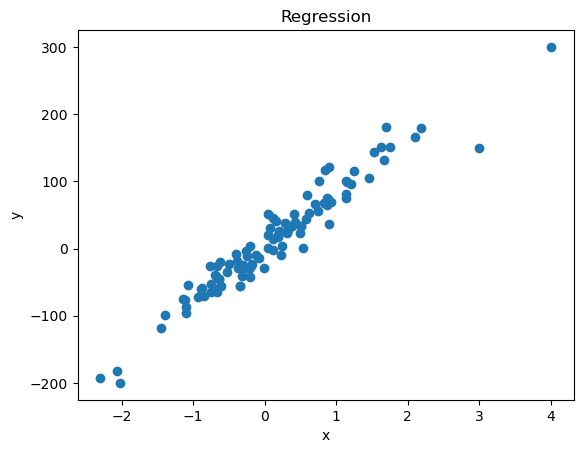

In [62]:
plt.scatter(X0, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression")

In [63]:
model = sm.OLS(pd.DataFrame(y), pd.DataFrame(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1464.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           1.61e-61
Time:                        13:07:51   Log-Likelihood:                -452.71
No. Observations:                 102   AIC:                             909.4
Df Residuals:                     100   BIC:                             914.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              3.2565      2.065      1.577      0.1

Text(0.5, 1.0, 'leverage')

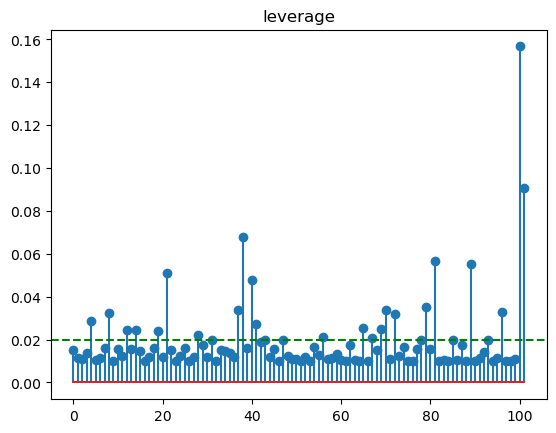

In [64]:
#영향도 값
influence = result.get_influence()
# 레버리지 벡터의 값
hat = influence.hat_matrix_diag
#print(hat)

#막대그래프와 비슷하지만 폭이 없는 그래프
plt.stem(hat)
#0.02에 가로 점선 추가
plt.axhline(0.02, c="g", ls="--")
plt.title("leverage")
#마지막에 추가한 이상치를 제외하면 대부분의 값들은 0.02 근처의 낮은 값들

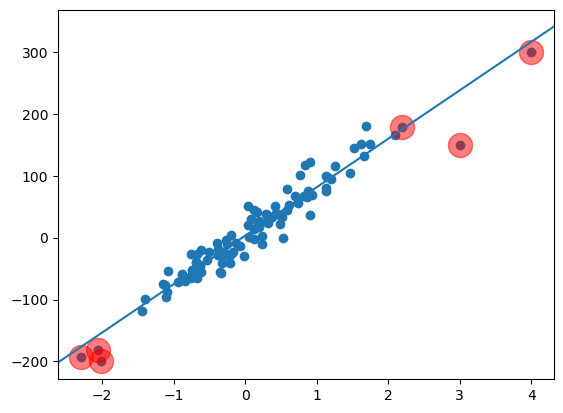

In [65]:
#레버리지 값이 0.05보다 큰 샘플 강조
ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, ax=ax)
idx = hat > 0.05
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
plt.show()

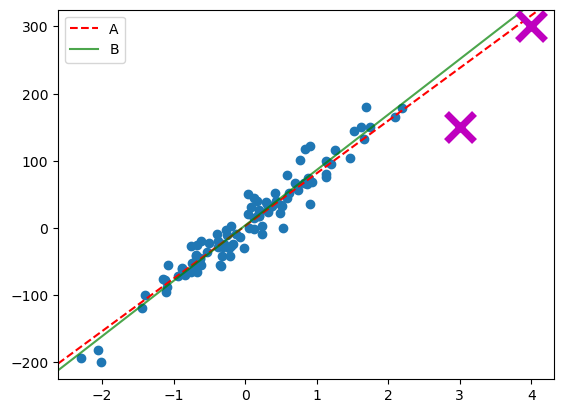

In [71]:
#레버리지가 높은 데이터가 회귀분석에 미치는 영향
model2 = sm.OLS(y[:-2], X[:-2]) #마지막 샘플 제외
result2 = model2.fit()

ax = plt.subplot()
plt.scatter(X0, y)

#레버리지가 큰 데이터를 포함한 모형
sm.graphics.abline_plot(model_results=result, c="r", linestyle="--", ax=ax, label='A')
#레버리지가 큰 데이터를 포함하지 않은 모형
sm.graphics.abline_plot(model_results=result2, c="g", alpha=0.7, ax=ax, label='B')

# ms(marker size), mew(marker edge width)
#이상치
plt.plot(X0[-1], y[-1], marker='x', c="m", ms=20, mew=5)
plt.plot(X0[-2], y[-2], marker='x', c="m", ms=20, mew=5)
plt.legend()
plt.show()

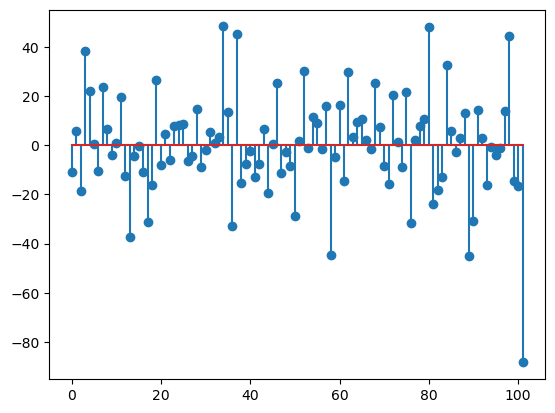

In [72]:
# 각 샘플의 잔차
plt.stem(result.resid)
plt.show()

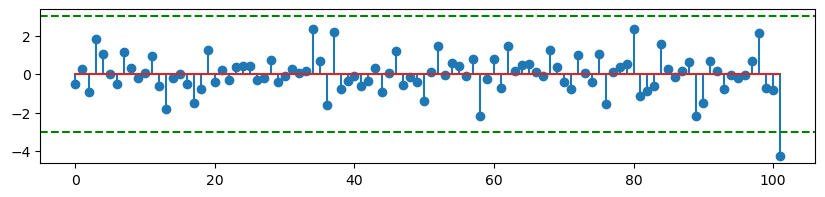

In [68]:
# 각 샘플의 표준화 잔차(잔차를 스케일링한 값, 일반적으로 2~4보다 크면 아웃라이어로 본다.)
plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson)
plt.axhline(3, c="g", ls="--")
plt.axhline(-3, c="g", ls="--")
plt.show()

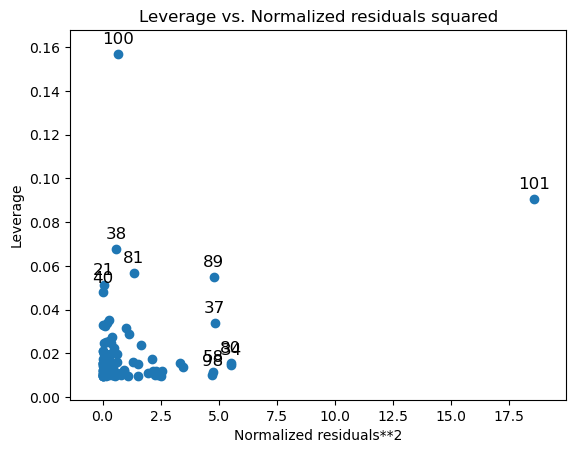

In [69]:
#레버리지와 잔차의 크기가 모두 큰 데이터들을 보기 위한 그래프
#x축: 표준화 잔차의 제곱, y축: 레버리지값
#숫자가 표시된 데이터들 확인
sm.graphics.plot_leverage_resid2(result)
plt.show()

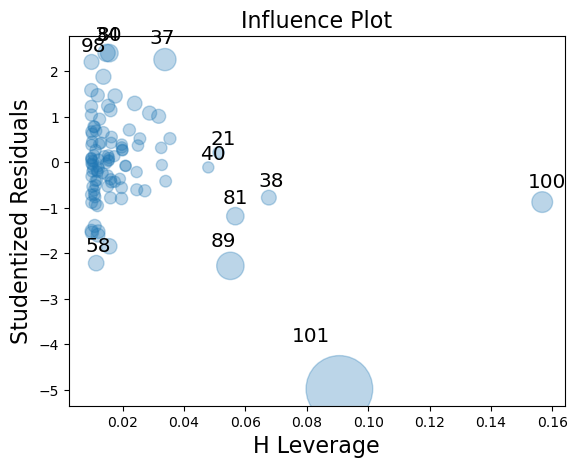

In [70]:
#레버리지와 잔차의 크기가 모두 큰 데이터들을 시각적으로 표현
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()
#샘플의 인덱스 확인(인덱스 100,101번이 outlier)

##### 이상치 - 주택데이터셋으로 실습

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()

In [74]:
dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)
# 회귀분석에서 수식을 간단하게 만들기 위해
# 독립변수의 첫번째 필드에 상수항 1을 추가(augmentation)
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

In [75]:
model_boston = sm.OLS(dfy, dfX)
result_boston = model_boston.fit()
print(result_boston.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          6.72e-135
Time:                        14:39:54   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.0

<AxesSubplot:>

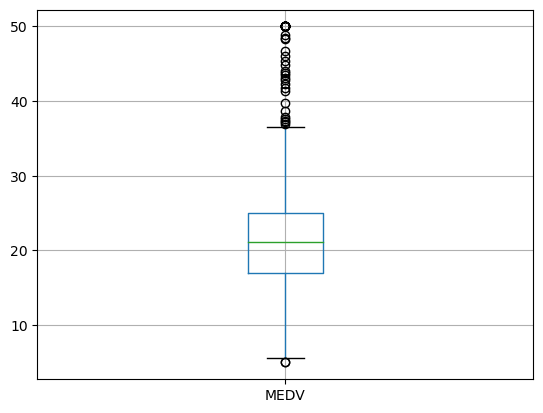

In [76]:
dfy.boxplot()

In [77]:
#주택가격이 40이상일 때 40으로 낮추는 방법
dfy.loc[dfy.MEDV >= 40, 'MEDV']=40
model_boston2=sm.OLS(dfy, dfX)
result_boston2=model_boston2.fit()
result_boston2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     135.8
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          2.23e-153
Time:                        14:40:16   Log-Likelihood:                -1385.7
No. Observations:                 506   AIC:                             2799.
Df Residuals:                     492   BIC:                             2859.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.1624      4.081      9.350      0.000      30.143      46.182
CRIM          -0.1109      0.026     -4.219      0.000      -0.163      -0.059
ZN             0.0370      0.011      3.374      0.001       0.015       0.059
INDUS         -0.0139      0.049     -0.283      0.777      -0.111       0.083
CHAS           1.7865      0.689      2.593      0.010       0.433       3.140
NOX          -15.4649      3.055     -5.062      0.000     -21.467      -9.463
RM             2.8793      0.334      8.615      0.000       2.223       3.536
AGE           -0.0060      0.011     -0.567      0.571      -0.027       0.015
DIS           -1.2519      0.160     -7.848      0.000      -1.565      -0.938
RAD            0.2704      0.053      5.096      0.000       0.166       0.375
TAX           -0.0116      0.003     -3.867      0.000      -0.018      -0.006
PTRATIO       -0.8203      0.105     -7.840      0.000      -1.026      -0.615
B              0.0083      0.002      3.843      0.000       0.004       0.012
LSTAT         -0.4797      0.041    -11.828      0.000      -0.559      -0.400
==============================================================================
Omnibus:                       93.466   Durbin-Watson:                   1.115
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.094
Skew:                           0.971   Prob(JB):                     2.39e-46
Kurtosis:                       5.488   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
# 이상치라고 생각되는 MEDV >= 40 이상인 값들
idx = np.where(dfy >= 40)[0]
idx

array([ 98, 157, 161, 162, 163, 166, 186, 195, 202, 203, 204, 224, 225,
       228, 232, 233, 253, 256, 257, 261, 262, 267, 268, 280, 282, 283,
       368, 369, 370, 371, 372], dtype=int64)

In [79]:
#아웃라이어를 제외한 후 회귀 분석을 한 결과
idx2 = list(set(range(len(dfX))).difference(idx))
#행인덱스를 새롭게 부여하고 인덱스 필드는 제거
dfX = dfX.iloc[idx2, :].reset_index(drop=True)
dfy = dfy.iloc[idx2, :].reset_index(drop=True)
model_boston3 = sm.OLS(dfy, dfX)
result_boston3 = model_boston2.fit()
print(result_boston3.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     135.8
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          2.23e-153
Time:                        14:40:43   Log-Likelihood:                -1385.7
No. Observations:                 506   AIC:                             2799.
Df Residuals:                     492   BIC:                             2859.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.1624      4.081      9.350      0.0

### 신용카드 거래 금액 예측

In [80]:
# 신용카드 거래 데이터 csv 파일을 로딩(원본)
df = pd.read_csv("c:/vscode/data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


c:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '분류\n (0: 정상거래 || 1: 사기거래)')

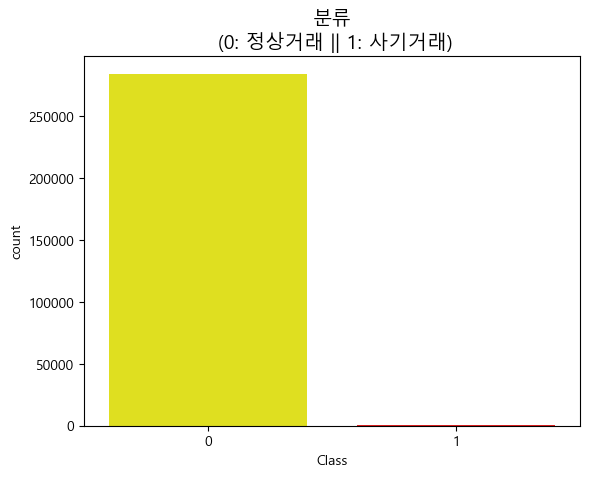

In [81]:
#한글 처리를 위해 폰트 설정
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
colors = ["yellow", "red"]
sns.countplot('Class', data=df, palette=colors)
plt.title('분류\n (0: 정상거래 || 1: 사기거래)', fontsize=14)
#불균형 데이터셋

In [82]:
print("사기거래")
print(df.Amount[df.Class == 1].describe())
print()
print("정상거래")
print(df.Amount[df.Class == 0].describe())
# 사기거래 492건, 정상거래 284315건

사기거래
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

정상거래
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


In [83]:
train_cols = df.columns[1:29]
print(train_cols)
X = df[train_cols] # 독립변수
y = df["Amount"]
print(X.head())
print(y.head())

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V19       V20       V21       V22  \
0  0.098698  0.363787  0.090794  ...  0.403993  0.251412 -0.018307  0.277838   
1  0.085102 -0.255425 -0.166974  ... -0.145783 -0.069083 -0.225775 -0.638672   
2  0.247676 -1.514654  0.207643  ... -2.261857  0.524980  0.247998  0.771679  

In [85]:
from sklearn.model_selection import train_test_split
#데이터셋을 나눔(학습용:검증용 = 8:2)
#random_state : 난수 발생을 위한 seed의 인자값
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=10)

In [86]:
#다중 회귀분석
import statsmodels.api as sm
model = sm.OLS(y_train, X_train)
result = model.fit()
print("회귀계수\n",result.params)
print("R-squared\n",result.rsquared)
print("P values\n",result.pvalues)
#요약 결과 출력
print(result.summary())
# 모델의 설명력 91.3%
# p-value를 확인해 볼 때 모든 변수가 유의한 것으로 나타남

회귀계수
 V1     -29.071163
V2     -80.740965
V3     -34.990065
V4      17.634759
V5     -70.401473
V6      40.960005
V7      80.872687
V8     -21.747735
V9      -9.858902
V10    -23.512566
V11     -0.032073
V12     -2.442332
V13      1.471566
V14      8.686637
V15     -0.765415
V16     -0.958718
V17      1.750542
V18     10.561197
V19    -17.228021
V20    109.111737
V21     36.131645
V22    -22.338471
V23    -45.934831
V24      2.164762
V25    -22.725643
V26     -1.270434
V27     19.827197
V28      7.125640
dtype: float64
R-squared
 0.8140433994103969
P values
 V1      0.000000e+00
V2      0.000000e+00
V3      0.000000e+00
V4      0.000000e+00
V5      0.000000e+00
V6      0.000000e+00
V7      0.000000e+00
V8      0.000000e+00
V9      0.000000e+00
V10     0.000000e+00
V11     8.908527e-01
V12     1.411787e-24
V13     8.025868e-10
V14    1.903362e-265
V15     3.279689e-03
V16     4.377964e-04
V17     4.152944e-10
V18    3.816983e-301
V19     0.000000e+00
V20     0.000000e+00
V21     0.00000

In [87]:
from sklearn.metrics import r2_score
pred=result.predict(X_test)
r2_score(y_test, pred)  #r value 계산

0.8000119299914439

In [88]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
print("학습용:",model.score(X_train, y_train))
print("검증용:",model.score(X_test, y_test))

학습용: 0.9166679569637542
검증용: 0.920240380985743


### HDI 데이터

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [90]:
# 전처리 과정을 거친 데이터 로딩
df = pd.read_csv("c:/vscode/data/hdi/hdi-data2.csv")
df.head()

,Life expectancy at birth,Mean years of schooling,Expected years of schooling,GNI,Export,HDI
0,48.4,3.5,8.2,280,85.119671,0.286
1,54.7,1.4,4.9,641,42.473864,0.295
2,50.4,2.7,10.5,368,42.473864,0.316
3,50.2,1.2,9.2,898,25.251291,0.322
4,49.6,1.5,7.2,1105,43.900000,0.328


In [91]:
train_cols = df.columns[0:5]
print(train_cols)
X = df[train_cols] # 독립변수
y = df["HDI"]
print(df[train_cols].head())
print(y.head())

Index(['Life expectancy at birth', 'Mean years of schooling',
       'Expected years of schooling', 'GNI', 'Export'],
      dtype='object')
   Life expectancy at birth  Mean years of schooling  \
0                      48.4                      3.5   
1                      54.7                      1.4   
2                      50.4                      2.7   
3                      50.2                      1.2   
4                      49.6                      1.5   

   Expected years of schooling   GNI     Export  
0                          8.2   280  85.119671  
1                          4.9   641  42.473864  
2                         10.5   368  42.473864  
3                          9.2   898  25.251291  
4                          7.2  1105  43.900000  
0    0.286
1    0.295
2    0.316
3    0.322
4    0.328
Name: HDI, dtype: float64


In [92]:
#다중 회귀분석
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

import statsmodels.api as sm
model = sm.OLS(y_train, X_train)
result = model.fit()

print("회귀계수\n",result.params)
print("R-squared\n",result.rsquared)
print("P values\n",result.pvalues)
#요약 결과 출력
print(result.summary())
# 모델의 설명력
# p-value를 확인해 볼 때 모든 변수가 유의한 것으로 나타남
from sklearn.metrics import r2_score
pred=result.predict(X_test)
rsquared=r2_score(y_test, pred)
rsquared

회귀계수
 Life expectancy at birth       0.004653
Mean years of schooling        0.022120
Expected years of schooling    0.011457
GNI                            0.000003
Export                        -0.000128
dtype: float64
R-squared
 0.9983302267104234
P values
 Life expectancy at birth       4.656765e-43
Mean years of schooling        2.521389e-31
Expected years of schooling    2.263664e-10
GNI                            1.533275e-28
Export                         1.509747e-01
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                    HDI   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.722e+04
Date:                Thu, 09 Mar 2023   Prob (F-statistic):                   5.06e-198
Time:                        15:16:23   Log-Likelihood:         

0.9258621508415219

In [93]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
print("학습용:",model.score(X_train, y_train))
print("검증용:",model.score(X_test, y_test))

학습용: 0.9795845422991336
검증용: 0.9432099785667011


### 난방효율성 데이터 분석

In [103]:
df = pd.read_csv("c:/vscode/data/ENB2012_data.csv")
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [104]:
train_cols = df.columns[0:8]
print(train_cols)
X = df[train_cols] # 독립변수
y = df["Y1"] # 난방 하중
print(df[train_cols].head())
print(y.head())

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'], dtype='object')
     X1     X2     X3      X4   X5  X6   X7  X8
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0
0    15.55
1    15.55
2    15.55
3    15.55
4    20.84
Name: Y1, dtype: float64


In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [107]:
#다중 회귀분석
import statsmodels.api as sm
model = sm.OLS(y_train, X_train)
result = model.fit()

print("회귀계수\n",result.params)
print("R-squared\n",result.rsquared)
print("P values\n",result.pvalues)
print(result.summary())

회귀계수
 X1   -21.114384
X2    -0.003032
X3     0.031192
X4    -0.017112
X5     5.385563
X6    -0.017253
X7    20.405945
X8     0.213261
dtype: float64
R-squared
 0.9848599675190215
P values
 X1    3.436249e-22
X2    4.057924e-02
X3    1.997717e-12
X4    1.889720e-09
X5    1.367608e-73
X6    8.760142e-01
X7    1.358458e-77
X8    9.518520e-03
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                     Y1   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              5641.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:40:12   Log-Likelihood:                         -1550.9
No. Observations:                 614   AIC:                                      3116.
Df Residuals:               

In [108]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
print("학습용:",model.score(X_train, y_train))
print("검증용:",model.score(X_test, y_test))

학습용: 0.9123488471973691
검증용: 0.9313289941747572


#### 냉방으로 분석

In [109]:
train_cols = df.columns[0:8]
print(train_cols)
X = df[train_cols] # 독립변수
y = df["Y2"] # 난방 하중
print(df[train_cols].head())
print(y.head())

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'], dtype='object')
     X1     X2     X3      X4   X5  X6   X7  X8
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0
0    21.33
1    21.33
2    21.33
3    21.33
4    28.28
Name: Y2, dtype: float64


In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [111]:
#다중 회귀분석
import statsmodels.api as sm
model = sm.OLS(y_train, X_train)
result = model.fit()

print("회귀계수\n",result.params)
print("R-squared\n",result.rsquared)
print("P values\n",result.pvalues)
print(result.summary())

회귀계수
 X1   -20.487582
X2     0.002893
X3     0.017357
X4    -0.007232
X5     5.684302
X6     0.181033
X7    14.943758
X8     0.045031
dtype: float64
R-squared
 0.9844548841401721
P values
 X1    4.208197e-18
X2    7.349407e-02
X3    2.745613e-04
X4    1.858363e-02
X5    7.131353e-70
X6    1.342746e-01
X7    2.807091e-41
X8    6.152559e-01
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                     Y2   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              5492.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:50:12   Log-Likelihood:                         -1605.1
No. Observations:                 614   AIC:                                      3224.
Df Residuals:               

In [112]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
print("학습용:",model.score(X_train, y_train))
print("검증용:",model.score(X_test, y_test))

학습용: 0.882472464160759
검증용: 0.9079786235531351


### 놀이기구 만족도 데이터

In [115]:
df = pd.read_csv("c:/vscode/data/rides/rides.csv")
print(df.head())

  weekend  num.child    distance  rides  games  wait  clean  overall
0     yes          0  114.648259     87     73    60     89       47
1     yes          2   27.014097     87     78    76     87       65
2      no          1   63.300975     85     80    70     88       61
3     yes          0   25.909931     88     72    66     89       37
4      no          4   54.718307     84     87    74     87       68


In [116]:
#범주형 변수 처리(주말여부)
df2=pd.get_dummies(df['weekend'],prefix='weekend')
df=pd.concat([df,df2],axis=1)
del df['weekend']
df.head()

,num.child,distance,rides,games,wait,clean,overall,weekend_no,weekend_yes
0,0,114.648259,87,73,60,89,47,0,1
1,2,27.014097,87,78,76,87,65,0,1
2,1,63.300975,85,80,70,88,61,1,0
3,0,25.909931,88,72,66,89,37,0,1
4,4,54.718307,84,87,74,87,68,1,0


In [117]:
#다중회귀분석
#독립변수
X=df[['num.child', 'distance', 'rides', 'games', 'wait', 'clean', 'weekend_no', 'weekend_yes']]
#종속변수
y=df['overall']

In [118]:
import statsmodels.api as sm
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     151.6
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          1.73e-118
Time:                        15:55:02   Log-Likelihood:                -1804.1
No. Observations:                 500   AIC:                             3624.
Df Residuals:                     492   BIC:                             3658.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
num.child       3.6160      0.270     13.403      0.000       3.086       4.146
distance        0.0449      0.012      3.686      0.000       0.021       0.069
rides           0.6136      0.121      5.072      0.000       0.376       0.851
games           0.1383      0.059      2.356      0.019       0.023       0.254
wait            0.5648      0.041     13.896      0.000       0.485       0.645
clean           0.9272      0.136      6.821      0.000       0.660       1.194
weekend_no   -140.6125      7.154    -19.655      0.000    -154.669    -126.556
weekend_yes  -141.3283      7.121    -19.847      0.000    -155.319    -127.337
==============================================================================
Omnibus:                        2.188   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.335   Jarque-Bera (JB):                1.943
Skew:                          -0.050   Prob(JB):                        0.379
Kurtosis:                       2.712   Cond. No.                     4.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [120]:
#자녀수, 거리, 놀이기구점수, 게임점수, 대기시간점수, 청결도, 평일여부, 주말여부
result.predict([2, 20, 80, 70, 80, 90, 0, 1])   #1차원 배열로 입력

array([54.20768166])

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#데이터셋을 나눔(학습용:검증용 = 8:2)
#random_state : 난수 발생을 위한 seed의 인자값
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
model = LinearRegression().fit(X_train, y_train)

In [123]:
print("학습용:",model.score(X_train, y_train))
print("검증용:",model.score(X_test, y_test))

학습용: 0.6670609590984946
검증용: 0.7212343349658576


In [124]:
model.predict([[2, 20, 80, 70, 80, 90, 0, 1]])  #2차원 배열로 입력

c:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([53.30062057])

In [126]:
# 만족도 예측 모형 저장하기
import joblib
joblib.dump(model, 'C:/vscode/data/rides/rides_regress.model')

['C:/vscode/data/rides/rides_regress.model']

##### 만족도 예측 모델 불러오기
* 파이참에서 웹으로 불러오기 가능

In [127]:
import joblib
model=joblib.load('C:/vscode/data/rides/rides_regress.model')

In [128]:
#자녀수, 거리, 놀이기구점수, 게임점수, 대기시간점수, 청결도, 평일여부, 주말여부
model.predict([[2, 20, 80, 70, 80, 90, 0, 1]])

c:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([53.30062057])

In [144]:
model.predict([[2, 100, 100, 100, 100, 100, 0, 1]])

c:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([92.88896959])

##### 모형의 진단과 수정

In [1]:
#기계학습모형의 성능을 진단하고 성능을 개선하는 과정
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
import pandas as pd

c:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fu

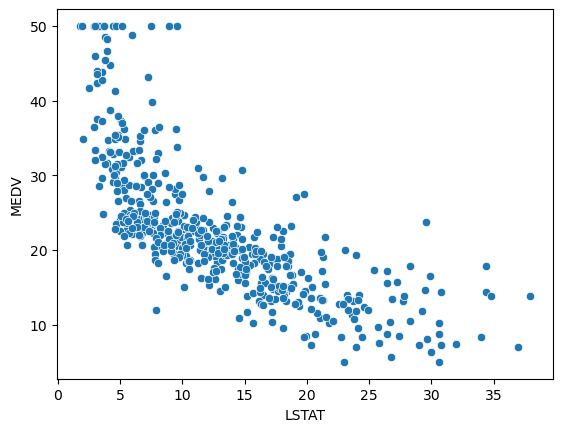

In [2]:
boston = load_boston()
dfx = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=['MEDV'])
df_boston = pd.concat([dfx,dfy], axis=1)
sns.scatterplot(x='LSTAT', y='MEDV', data=df_boston)
plt.show()

In [3]:
import statsmodels.api as sm

model1 = sm.OLS.from_formula('MEDV ~ LSTAT', data=df_boston)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           5.08e-88
Time:                        12:08:34   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

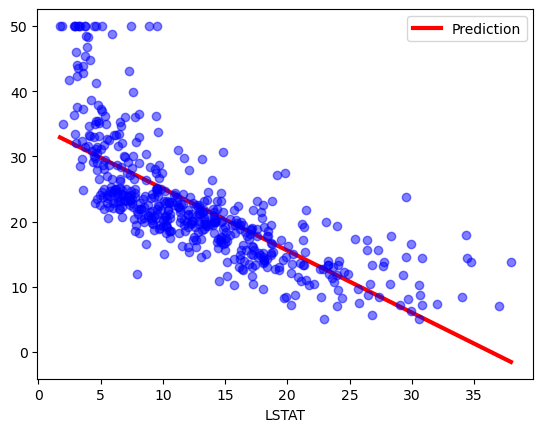

In [4]:
#예측값과 실제값 비교
y_hat1 = result1.predict(df_boston)
df1 = pd.concat([y_hat1, df_boston.LSTAT], axis=1).sort_values('LSTAT')
df1.columns = ['Prediction', 'LSTAT']

df1.plot(x='LSTAT', style='r-', lw=3)
plt.plot(df_boston.LSTAT, df_boston.MEDV, 'bo', alpha=0.5)
plt.show()
#예측력이 약한 모형

In [6]:
#LSTAT을 제곱한 비선형 독립변수를 추가한 모형
model2 = sm.OLS.from_formula('MEDV ~ LSTAT + I(LSTAT**2)', data=df_boston)  
                                         # I() -> 정수로 바꾸는 함수(integer)
result2 = model2.fit()
print(result2.summary())
#성능이 향상됨 54.4% => 64.1%

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Fri, 10 Mar 2023   Prob (F-statistic):          1.56e-112
Time:                        12:14:05   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149

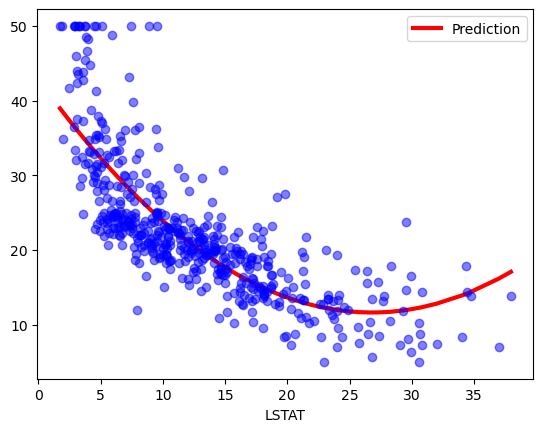

In [7]:
y_hat2 = result2.predict(df_boston)
df2 = pd.concat([y_hat2, df_boston.LSTAT], axis=1).sort_values("LSTAT")
df2.columns = ["Prediction", "LSTAT"]
df2.plot(x="LSTAT", style="r-", lw=3)
plt.plot(df_boston.LSTAT, df_boston.MEDV, "bo", alpha=0.5)
plt.show()
#선형모형보다 좀더 적합한 모형

##### 범주형 변수 > 카테고리형으로 바꾸기

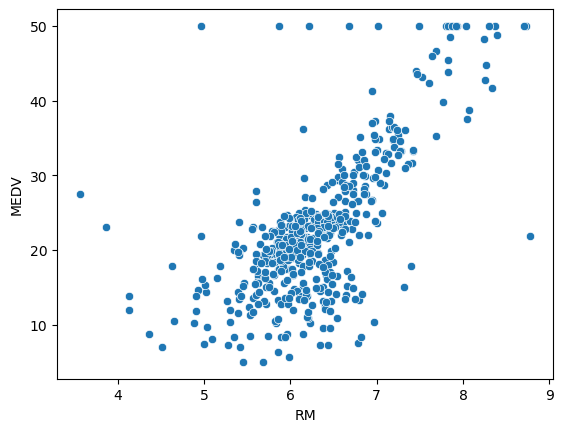

0      6.575
1      6.421
2      7.185
3      6.998
4      7.147
       ...  
501    6.593
502    6.120
503    6.976
504    6.794
505    6.030
Name: RM, Length: 506, dtype: float64


In [8]:
sns.scatterplot(x="RM", y="MEDV", data=df_boston)
plt.show()
print(df_boston['RM'])
# 방의 개수가 아주 적거나 아주 많으면 선형모형이 잘 맞지 않는다.

In [9]:
model3 = sm.OLS.from_formula("MEDV ~ RM", data=df_boston)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           2.49e-74
Time:                        12:31:17   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

<AxesSubplot:xlabel='CAT_RM', ylabel='MEDV'>

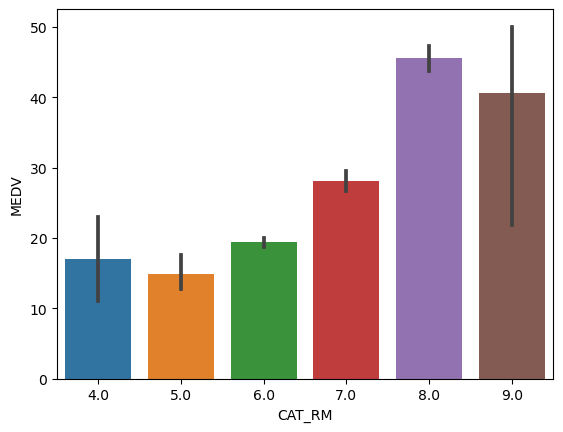

In [10]:
import numpy as np
df_boston["CAT_RM"] = np.round(df_boston.RM)
sns.barplot(x="CAT_RM", y="MEDV", data=df_boston)

In [11]:
#실수형을 정수형으로 바꾸고 더미변수를 사용한 모형
model4 = sm.OLS.from_formula("MEDV ~ C(np.round(RM))+0",
data=df_boston)
result4 = model4.fit()
print(result4.summary())
# 성능이 개선됨 48.4 => 53.7%

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     115.8
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           3.57e-81
Time:                        12:32:12   Log-Likelihood:                -1645.6
No. Observations:                 506   AIC:                             3303.
Df Residuals:                     500   BIC:                             3329.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(np.round(RM))[4.0]    17.0200 

##### 독립변수가 시간인 경우 변형

In [12]:
#일자별 전력수요량
df=pd.read_csv('C:/vscode/data/energy_data.csv')
df.head()

,Unnamed: 0,Demand,Date
0,0,174.896295,2019-01-01
1,1,188.590935,2019-01-02
2,2,188.916891,2019-01-03
3,3,173.814244,2019-01-04
4,4,169.515175,2019-01-05


In [13]:
import datetime as dt

df['Date'] = pd.to_datetime(df['Date'])

# toordinal 서기 1년 1월 1일을 기준으로 경과한 날짜
df["Ordinal"] = df.Date.map(dt.datetime.toordinal)
df["Timestamp"] = df.Date.map(dt.datetime.timestamp)
df.head()

,Unnamed: 0,Demand,Date,Ordinal,Timestamp
0,0,174.896295,2019-01-01,737060,1.546268e+09
1,1,188.590935,2019-01-02,737061,1.546355e+09
2,2,188.916891,2019-01-03,737062,1.546441e+09
3,3,173.814244,2019-01-04,737063,1.546528e+09
4,4,169.515175,2019-01-05,737064,1.546614e+09


In [14]:
#일단위 날짜를 기준으로 분석, 날짜는 단위가 크므로 스케일링이 필요함
model5 = sm.OLS.from_formula("Demand ~ scale(Ordinal)", data=df)
result5 = model5.fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     11.58
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           0.000739
Time:                        12:40:57   Log-Likelihood:                -1709.7
No. Observations:                 365   AIC:                             3423.
Df Residuals:                     363   BIC:                             3431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        221.2775      1.374    160.

In [15]:
#시간에서 활용할 수 있는 추가적인 필드들
df["Year"] = df.Date.dt.year
df["Month"] = df.Date.dt.month
df["DayOfYear"] = df.Date.dt.dayofyear #연중 몇일차
df["DayOfMonth"] = df.Date.dt.daysinmonth #일수
df["DayOfWeek"] = df.Date.dt.dayofweek
df["WeekOfYear"] = df.Date.dt.weekofyear #연중 몇주차
df["Weekday"] = df.Date.dt.weekday #요일코드
df["IsMonthStart"] = df.Date.dt.is_month_start
df["IsMonthEnd"] = df.Date.dt.is_month_end
df.tail()

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_2712\799855565.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["WeekOfYear"] = df.Date.dt.weekofyear #연중 몇주차


,Unnamed: 0,Demand,Date,Ordinal,Timestamp,Year,Month,DayOfYear,DayOfMonth,DayOfWeek,WeekOfYear,Weekday,IsMonthStart,IsMonthEnd
360,360,173.727990,2019-12-27,737420,1.577372e+09,2019,12,361,31,4,52,4,False,False
361,361,188.512817,2019-12-28,737421,1.577459e+09,2019,12,362,31,5,52,5,False,False
362,362,191.273009,2019-12-29,737422,1.577545e+09,2019,12,363,31,6,52,6,False,False
363,363,186.240144,2019-12-30,737423,1.577632e+09,2019,12,364,31,0,1,0,False,False
364,364,186.370181,2019-12-31,737424,1.577718e+09,2019,12,365,31,1,1,1,False,True


In [16]:
formula = """
Demand ~ scale(Ordinal) + C(Month)+0 + DayOfYear + 
C(DayOfMonth)+0 + C(DayOfWeek)+0 + C(Weekday)+0 +
C(IsMonthStart)+0 + C(IsMonthEnd)+0
"""

model6 = sm.OLS.from_formula(formula, data=df)
result6 = model6.fit()
print(result6.summary())
#3.1%에서 53.7%로 향상됨

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     19.98
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           4.74e-46
Time:                        12:42:29   Log-Likelihood:                -1574.8
No. Observations:                 365   AIC:                             3192.
Df Residuals:                     344   BIC:                             3273.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
C(Month)[1]               

##### 종속변수 변형

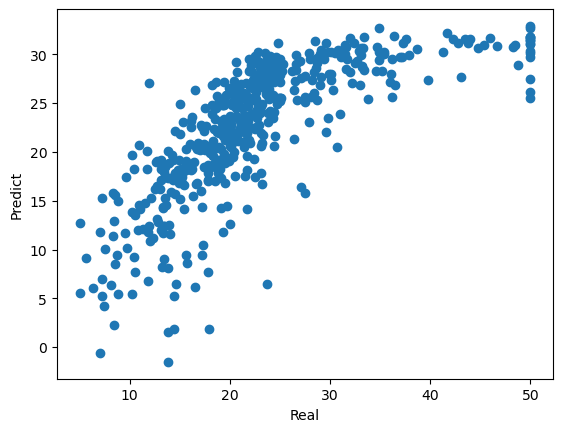

In [17]:
#실제주택가격과 예측값의 비교
plt.scatter(boston.target, y_hat1)
plt.xlabel('Real')
plt.ylabel('Predict')
plt.show()
#선형적으로 설명하기 어려운 모형

In [18]:
#종속변수를 제곱근 처리
model11 = sm.OLS.from_formula("np.sqrt(MEDV) ~ LSTAT", data=df_boston)
result11 = model11.fit()
print(result11.summary())

                            OLS Regression Results                            
Dep. Variable:          np.sqrt(MEDV)   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     789.7
Date:                Fri, 10 Mar 2023   Prob (F-statistic):          3.09e-105
Time:                        12:55:32   Log-Likelihood:                -445.65
No. Observations:                 506   AIC:                             895.3
Df Residuals:                     504   BIC:                             903.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9499      0.053    112.374      0.0

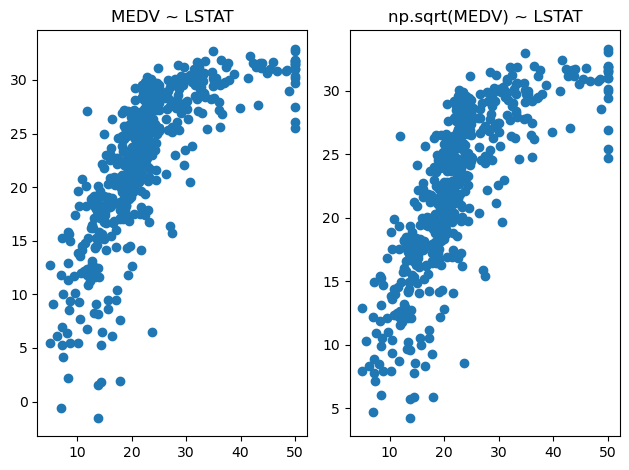

In [19]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, (result11.predict(df_boston))**2)
plt.title("np.sqrt(MEDV) ~ LSTAT")
plt.tight_layout()
plt.show()

In [20]:
#로그를 취한 모형
model12 = sm.OLS.from_formula("np.log(MEDV) ~ LSTAT",
data=df_boston)
result12 = model12.fit()
print(result12.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     928.1
Date:                Fri, 10 Mar 2023   Prob (F-statistic):          2.23e-116
Time:                        12:55:57   Log-Likelihood:               -0.57634
No. Observations:                 506   AIC:                             5.153
Df Residuals:                     504   BIC:                             13.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6176      0.022    164.654      0.0

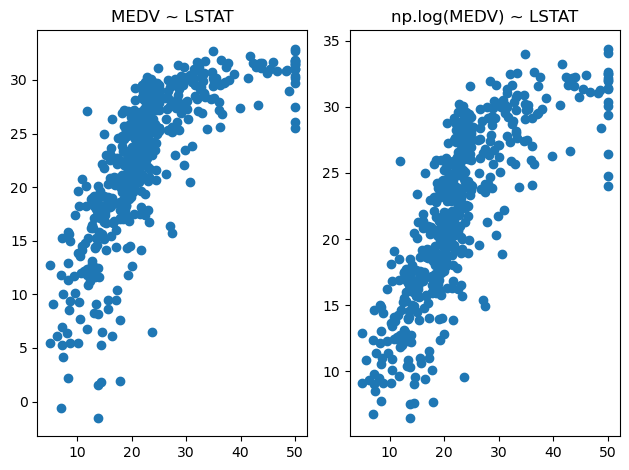

In [21]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, np.exp(result12.predict(df_boston)))
plt.title("np.log(MEDV) ~ LSTAT")
plt.tight_layout()
plt.show()

In [22]:
#독립변수와 종속변수 모두 로그를 취한 모형(가장 성능이 좋은 모형)
model13=sm.OLS.from_formula("np.log(MEDV) ~ np.log(LSTAT)", data=df_boston)
result13 = model13.fit()
print(result13.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     1058.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):          7.32e-126
Time:                        12:56:47   Log-Likelihood:                 21.325
No. Observations:                 506   AIC:                            -38.65
Df Residuals:                     504   BIC:                            -30.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3618      0.042    103.603

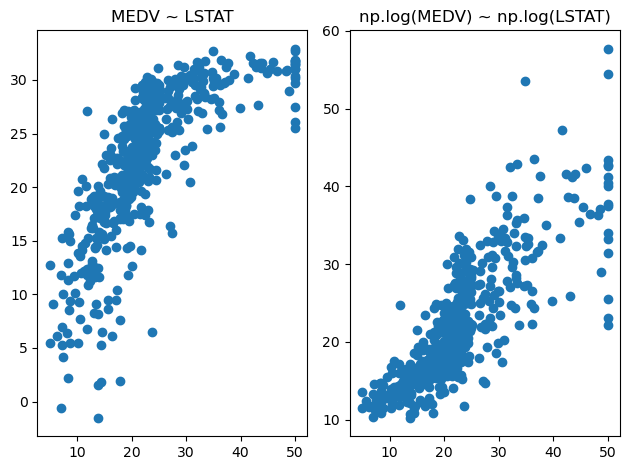

In [23]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, np.exp(result13.predict(df_boston)))
plt.title("np.log(MEDV) ~ np.log(LSTAT)")
plt.tight_layout()
plt.show()